In [42]:

import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
import sys
import numpy as np
import tensorflow as tf
sys.path.append('c:/python310/lib/site-packages/tensorflow_privacy/')

from privacy.analysis import compute_dp_sgd_privacy


def clip_grad(grad, C):
    return grad/np.max([1, np.linalg.norm(grad)/C])

def add_grad_noise(grad, sigma, C):
    return grad + np.random.normal(0, sigma, grad.shape)

# Load the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Preprocess
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]




In [43]:

def get_accuracy(x, y, w, b):
    scores = np.dot(x, w.T) + b
    probs = 1 / (1 + np.exp(-scores))
    y_pred = np.argmax(probs, axis=1)
    accuracy = np.mean(y_pred == np.argmax(y, axis=1))
    return accuracy

def compute_epsilon(batch_size, delta, sigma, iterations):
    eps = compute_dp_sgd_privacy.compute_dp_sgd_privacy(
        n=60000,
        batch_size=batch_size,
        noise_multiplier=sigma,
        epochs=iterations,
        delta=delta)
    return eps[0]
    

def logistic_regression_sgd(X, y, learning_rate, num_epochs, batch_size, do_dp=False, C=0.5, sigma=0.5, delta=1e-5, track_acc=False):
    N, D = X.shape
    K = y.shape[1]
    w = np.zeros((K, D))
    b = np.zeros(K)
    
    losses = np.zeros(num_epochs)
    test_accs = np.zeros(num_epochs)
    train_accs = np.zeros(num_epochs)
    epsilons = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        # Shuffle the data
        perm = np.random.permutation(N)
        X = X[perm]
        y = y[perm]

        loss_avg = 0
        # Process the data in batches
        for i in range(0, N, batch_size):
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]

            # Forward pass
            scores = np.dot(X_batch, w.T) + b
            probs = 1 / (1 + np.exp(-scores))
            loss = -1/batch_size * \
                np.sum(y_batch * np.log(probs) + (1-y_batch) * np.log(1-probs))

            # Backward pass
            dscores = 1/batch_size * (probs - y_batch)
            grad_w = np.dot(dscores.T, X_batch)
            grad_b = np.sum(dscores, axis=0)

            if do_dp:
                grad_w = clip_grad(grad_w, C)
                grad_w = add_grad_noise(grad_w, sigma, C)
                grad_b = clip_grad(grad_b, C)
                grad_b = add_grad_noise(grad_b, sigma, C)

            # Update weights
            w -= learning_rate * grad_w
            b -= learning_rate * grad_b
            loss_avg += loss

        # Print loss every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: loss = {loss:.6f}")
        if track_acc:
            test_accs[epoch] = get_accuracy(x_test, y_test, w, b)
            train_accs[epoch] = get_accuracy(x_train, y_train, w, b)
            losses[epoch] = loss_avg/(N/batch_size)
        if do_dp:
            epsilons[epoch] = compute_epsilon(batch_size, delta, sigma, epoch+1)
    return w, b, epsilons, test_accs


In [44]:

sigmas = [0.1, 0.5, 1, 2, 5, 10]
epsilons = []
testaccs = []
for s in sigmas:
    w, b, eps, testacc = logistic_regression_sgd(x_train, y_train, learning_rate=0.01,
                               num_epochs=50, batch_size=600, do_dp=True, track_acc=True, sigma=s)
    epsilons.append(eps)
    testaccs.append(testacc)

w,b,eps,testacc = logistic_regression_sgd(x_train, y_train, learning_rate=0.01,
                                 num_epochs=50, batch_size=600, do_dp=False, track_acc=True)
testaccs.append(testacc)


Epoch 0: loss = 3.513717


Epoch 10: loss = 1.503768


Epoch 20: loss = 1.291338


Epoch 30: loss = 1.167669


Epoch 40: loss = 1.108632


Epoch 0: loss = 3.893041


Epoch 10: loss = 1.680529


Epoch 20: loss = 1.441420


Epoch 30: loss = 1.492544


Epoch 40: loss = 1.489609


Epoch 0: loss = 4.383685


Epoch 10: loss = 2.527913


Epoch 20: loss = 2.644547


Epoch 30: loss = 2.457486


Epoch 40: loss = 2.490003


Epoch 0: loss = 4.948102


Epoch 10: loss = 6.849965


Epoch 20: loss = 5.955085


Epoch 30: loss = 5.796833


C:\Users\Julian\AppData\Local\Temp\ipykernel_22204\2370066252.py:45: RuntimeWarning: divide by zero encountered in log
  np.sum(y_batch * np.log(probs) + (1-y_batch) * np.log(1-probs))


Epoch 40: loss = 6.960152


C:\Users\Julian\AppData\Local\Temp\ipykernel_22204\2370066252.py:45: RuntimeWarning: invalid value encountered in multiply
  np.sum(y_batch * np.log(probs) + (1-y_batch) * np.log(1-probs))


Epoch 0: loss = 23.138275


Epoch 10: loss = 31.684753


Epoch 20: loss = inf


Epoch 30: loss = nan


Epoch 40: loss = nan


Epoch 0: loss = 23.543059


Epoch 10: loss = nan


Epoch 20: loss = nan


Epoch 30: loss = nan


Epoch 40: loss = nan


Epoch 0: loss = 2.475543
Epoch 10: loss = 1.408902
Epoch 20: loss = 1.311841
Epoch 30: loss = 1.154170
Epoch 40: loss = 1.156254


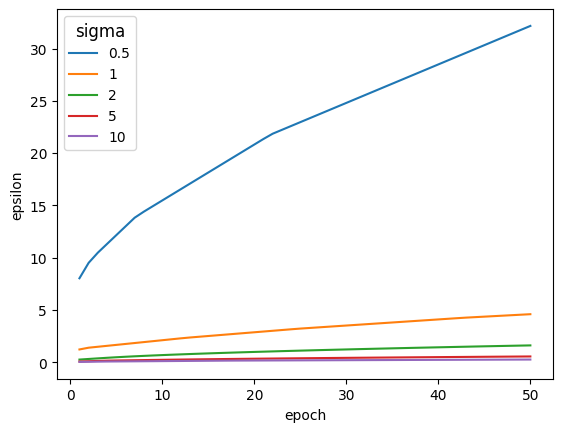

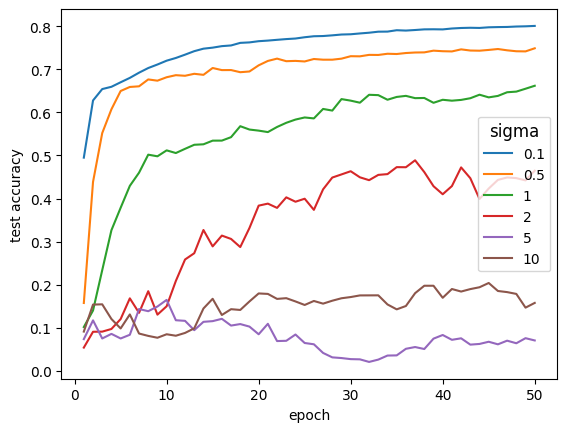

Accuracy: 0.7393


In [54]:
# plot epochs vs epsilon
sigmas = [0.4, 0.5, 0.6, 1, 2, 5]
for i in range(len(sigmas)):
    plt.plot(np.arange(1, 51), epsilons[i], label=sigmas[i])
plt.xlabel("epoch")
plt.ylabel("epsilon")
legend = plt.legend(sigmas)
legend.set_title('sigma', prop={'size': 12})
plt.show()

sigmas.append("0 (no DP)")
for i in range(len(sigmas)):
    plt.plot(np.arange(1, 51), testaccs[i], label=sigmas[i])
plt.xlabel("epoch")
plt.ylabel("test accuracy")
legend = plt.legend(sigmas)
legend.set_title('sigma', prop={'size': 12})
plt.show()
sigmas.pop()

# Evaluate the model on the test set
accuracy = get_accuracy(x_test, y_test, w, b)
print(f"Accuracy: {accuracy:.4f}")


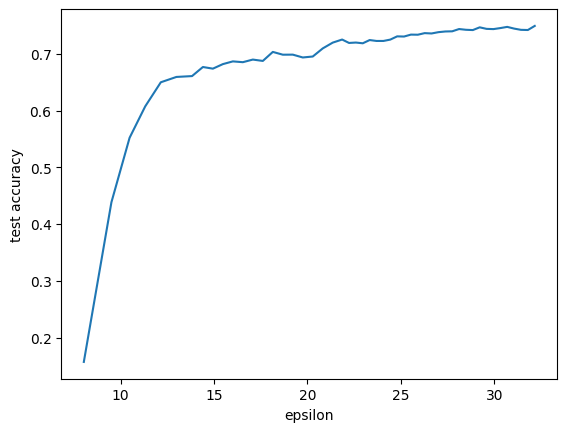

In [46]:
# plot accuracy vs epsilon, for the 0.5 sigma case
plt.plot(epsilons[1], testaccs[1])
plt.xlabel("epsilon")
plt.ylabel("test accuracy")
plt.show()


In [52]:
# print out last accuracy and epsilon for each sigma
for i in range(len(sigmas)):
    print("sigma: ", sigmas[i], "epsilon: {:.2f}".format(epsilons[i][-2]), "accuracy: {:.2f}".format(testaccs[i][-2]))

sigma:  0.1 epsilon: 193467.88 accuracy: 0.80
sigma:  0.5 epsilon: 31.79 accuracy: 0.74
sigma:  1 epsilon: 4.55 accuracy: 0.66
sigma:  2 epsilon: 1.60 accuracy: 0.44
sigma:  5 epsilon: 0.55 accuracy: 0.08
sigma:  10 epsilon: 0.26 accuracy: 0.15
